In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from random import sample

from itertools import chain
from random import sample 
import scipy
from skimage.io import imread, imshow

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
566,00002919_004.png,Infiltration,4,2919,047Y,F,PA,2992,2991,0.143,0.143
1242,00006522_005.png,No Finding,5,6522,053Y,F,PA,2500,2048,0.168,0.168
402,00002106_001.png,Pneumothorax,1,2106,030Y,M,PA,2814,2991,0.143,0.143


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


[Text(0, 0.5, 'Number of Images with Label')]

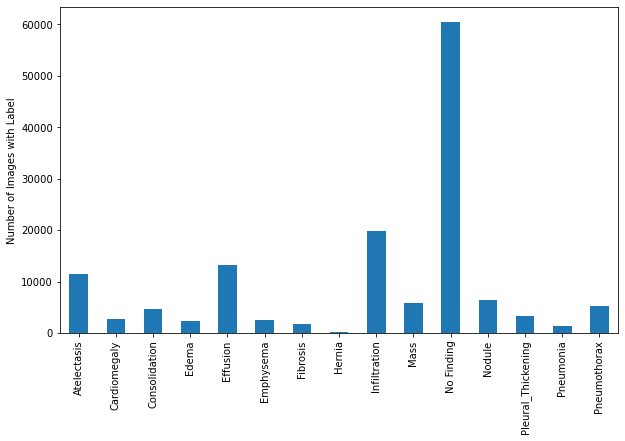

In [41]:
#Split up diagnoses
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

#Frequencies of diseases
plt.figure(figsize=(10,6))
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Text(0.5, 1.0, 'Follow-up #')

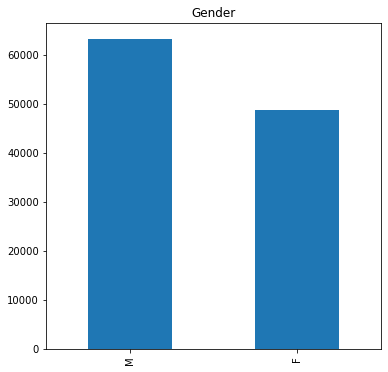

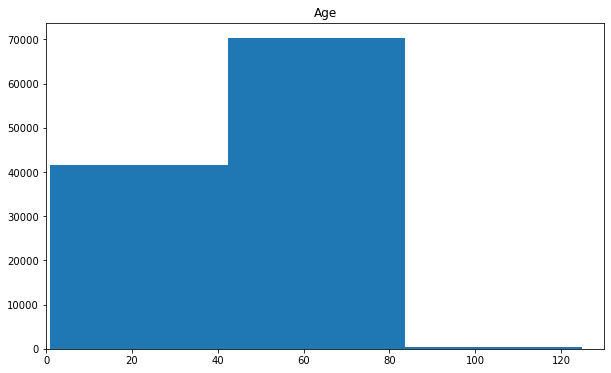

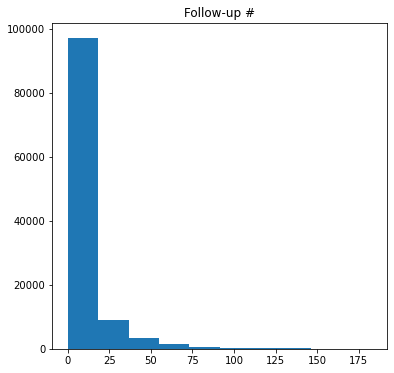

In [16]:
#Demographics of dataset
#Gender 
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender')

#Age
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'])
plt.xlim(0, 130)
plt.title('Age')

#Patient position
plt.figure(figsize=(6,6))
plt.hist(all_xray_df['Follow-up #'])
plt.title('Follow-up #')

Text(0.5, 1.0, 'Xray Position')

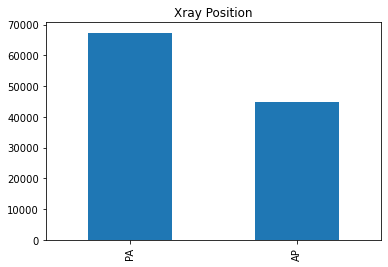

In [17]:
plt.figure()
all_xray_df['View Position'].value_counts().plot(kind='bar')
plt.title('Xray Position')

Text(0.5, 1.0, 'Age')

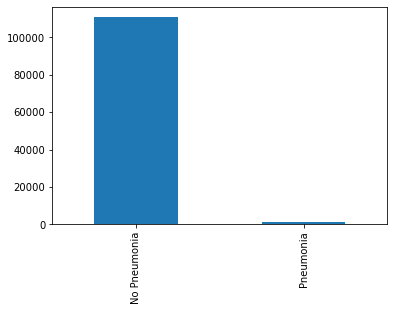

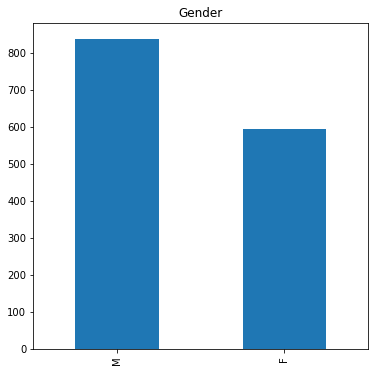

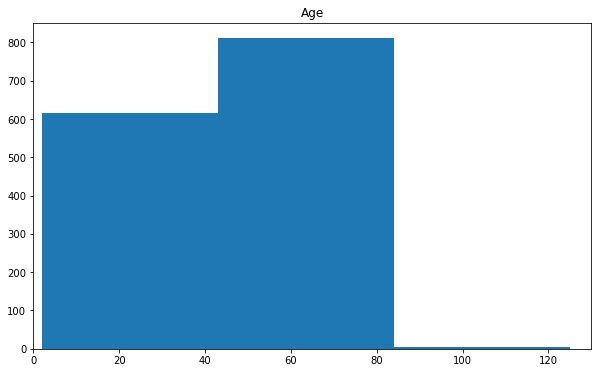

In [28]:
#Number of pneumonia cases
plt.figure()
all_xray_df['Pneumonia'].value_counts().plot(kind='bar')
plt.xticks([0,1],['No Pneumonia','Pneumonia'])

#Gender-pneumonia
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Gender')

#Age-pneumonia
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'])
plt.xlim(0, 130)
plt.title('Age')

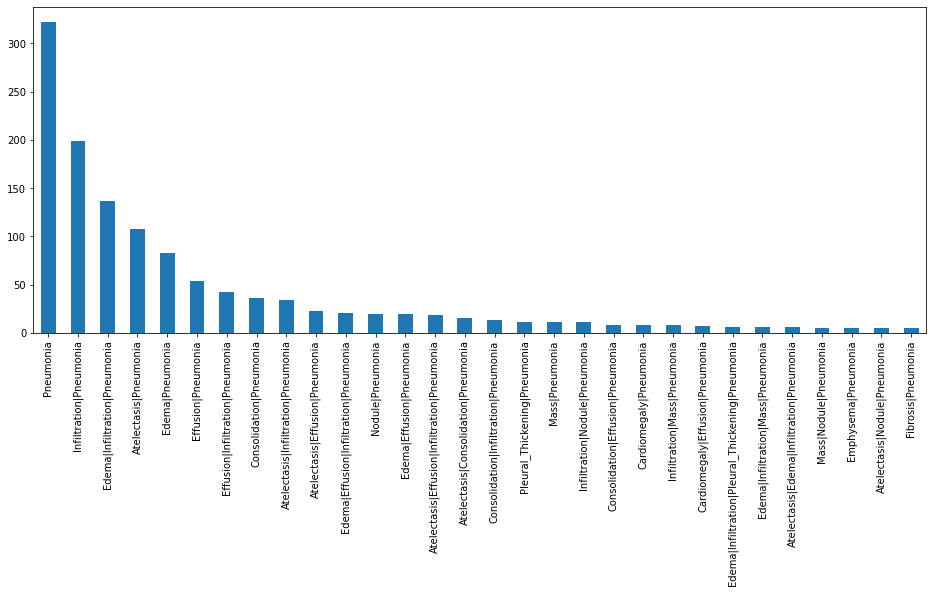

In [21]:
#Comorbidity with pneumonia
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

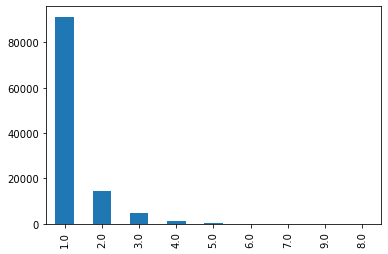

In [25]:
#Number of diseases of each patient
num_diseases = all_xray_df[all_labels].sum(axis=1)
plt.figure()
num_diseases.value_counts().plot(kind='bar')

In [3]:
#Pixel level assessment
#Load sample images
sample_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(sample_image_paths), ', Total Headers', all_xray_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(sample_image_paths.get)
sample_df['path'].sample(3)

Scans found: 112120 , Total Headers 112120


2869    /data/images_007/images/00014182_005.png
899     /data/images_003/images/00004795_000.png
2397    /data/images_006/images/00012089_010.png
Name: path, dtype: object

In [4]:
#Split up diagnoses
sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
sample_labels = [x for x in sample_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(sample_labels), sample_labels))
for c_label in sample_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3909,00019271_013.png,Atelectasis|Infiltration,13,19271,054Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,00011579_007.png,No Finding,7,11579,057Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4867,00025603_007.png,Infiltration|Pneumothorax,7,25603,045Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
sample_df['pixels'] = sample_df['path'].map(lambda path: imread(path).ravel())

In [6]:
#Pneumonia intensity values
pneumonia = []
sample_pneumonia = sample_df[sample_df.Pneumonia==1]
for pix in sample_pneumonia['pixels']:
    new_pix = pix.copy()
    new_pix = (new_pix - np.mean(new_pix))/np.std(new_pix)
    pneumonia.extend(new_pix.ravel())

(array([2.387000e+03, 1.000000e+00, 1.630000e+02, 1.484000e+03,
        3.392000e+03, 2.181000e+03, 9.700000e+02, 4.810000e+02,
        7.010000e+02, 6.430000e+02, 8.630000e+02, 7.780000e+02,
        1.024000e+03, 9.100000e+02, 2.346900e+04, 2.030000e+03,
        3.540000e+03, 4.273000e+03, 6.969000e+03, 3.139000e+03,
        6.119000e+03, 8.036000e+03, 8.117000e+03, 1.648600e+04,
        4.879600e+04, 5.993500e+04, 5.323200e+04, 6.155100e+04,
        2.335390e+05, 2.027510e+05, 2.993880e+05, 4.935220e+05,
        8.475560e+05, 1.317110e+06, 9.864990e+05, 1.001711e+06,
        1.309540e+06, 1.123189e+06, 1.458332e+06, 1.194594e+06,
        1.198768e+06, 1.760697e+06, 1.515160e+06, 1.713310e+06,
        1.783137e+06, 1.908116e+06, 2.070374e+06, 2.154186e+06,
        2.353048e+06, 2.475126e+06, 2.599537e+06, 2.817096e+06,
        2.765482e+06, 2.742622e+06, 2.836980e+06, 2.803275e+06,
        2.876091e+06, 2.626376e+06, 3.506407e+06, 2.282529e+06,
        2.219064e+06, 2.205389e+06, 1.89

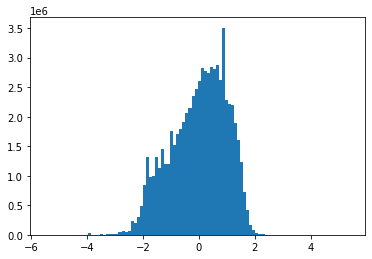

In [10]:
plt.figure()
plt.hist(pneumonia,bins=100)

In [8]:
#No pneumonia intensity values
no_pneumonia = []
sample_no_pneumonia = sample_df[sample_df.Pneumonia==0].sample(60)
for pix in sample_no_pneumonia['pixels']:
    new_pix = pix.copy()
    new_pix = (new_pix - np.mean(new_pix))/np.std(new_pix)
    no_pneumonia.extend(new_pix.ravel())

(array([9.264000e+03, 2.660000e+02, 1.170000e+02, 1.140000e+02,
        1.267700e+04, 1.758500e+04, 8.614000e+03, 9.372000e+03,
        9.817400e+04, 4.077800e+04, 2.367100e+04, 2.513100e+04,
        3.339800e+04, 9.976000e+04, 1.763320e+05, 2.434530e+05,
        2.110140e+05, 2.779860e+05, 1.783000e+05, 1.982690e+05,
        2.322880e+05, 4.849930e+05, 3.923490e+05, 5.038420e+05,
        7.218460e+05, 7.383570e+05, 7.875800e+05, 1.068257e+06,
        8.232860e+05, 1.081777e+06, 1.053580e+06, 1.120673e+06,
        1.243136e+06, 1.353650e+06, 1.465698e+06, 2.053664e+06,
        2.325136e+06, 1.740730e+06, 1.742664e+06, 1.802318e+06,
        1.821198e+06, 1.907550e+06, 1.982687e+06, 2.097850e+06,
        2.196576e+06, 2.209678e+06, 2.268545e+06, 2.314033e+06,
        2.333780e+06, 2.264191e+06, 2.296422e+06, 2.095225e+06,
        1.849950e+06, 1.753247e+06, 1.711096e+06, 1.705511e+06,
        2.817881e+06, 1.486234e+06, 1.274694e+06, 1.003866e+06,
        7.449500e+05, 5.699560e+05, 4.04

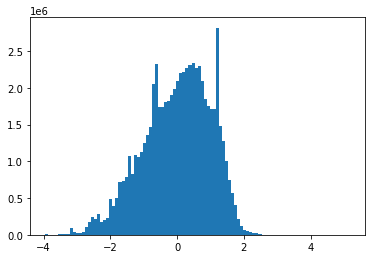

In [11]:
plt.figure()
plt.hist(no_pneumonia,bins=100)